## Referencce website 
code from https://blog.csdn.net/dgvv4/article/details/122023047

### **Import library**

In [1]:
import cv2
import csv
import os
import time
import mediapipe as mp
import sqlite3
import numpy as np
from datetime import datetime
from music21 import pitch, note, stream, midi,chord
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax

n_note = 100
use_model = True

### **Visualize hand landmarks and connections**

In [2]:
pTime = 0 #处理一张图像前的时间
cTime = 0 #一张图处理完的时间

# 存放坐标信息
lmList = []
captured_coordinates = []

In [3]:
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(40, 1), return_sequences=True)) #添加第一个长短时记忆（LSTM）层，其中有512个神经元。LSTM层通常用于处理序列数据。
#X shape is(L_datapoints, length, 1)，
#X.shape[1]and X.shape[2] means the second and the third feature of X shape，which are ‘length’and‘1’
#X的形状（shape）是指X这个数组在各个维度上的大小。在NumPy中，一个数组的形状可以通过其shape属性来访问，它是一个元组，其中包含了数组在每个维度上的大小。
#例如，如果X是一个三维数组，其中第一个维度有L_datapoints个元素，第二个维度有length个元素，第三个维度有1个元素，那么X的形状就是(L_datapoints, length, 1)。
model.add(Dropout(0.1))
#Dropout Layer: This layer is a special type of layer used to "drop" a random fraction of the neurons' outputs during training. 
#By doing so, the network is forced to learn more robust and generalized representations.
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(229, activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

model.load_weights("model_X+notes.h5")

In [4]:
import pickle
with open('mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

with open('reverse_mapping.pkl', 'rb') as f:
    reverse_mapping = pickle.load(f)

with open('L_corpus.pkl', 'rb') as f:
    L_corpus = pickle.load(f)

with open('L_symb.pkl', 'rb') as f:
    L_symb = pickle.load(f)
    
with open('Corpus.pkl', 'rb') as f:
    Corpus = pickle.load(f)

#Splitting the Corpus in equal length of strings and output target
length = 40
features = [] # 这两行创建了两个空列表，分别用来存储训练数据的输入特征（即音符序列）和目标（即接下来的音符）。
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)
seed = X_seed[0]

Total number of sequences in the Corpus: 55762


In [17]:
def generate_notes(model, seed_sequence, num_notes_to_generate):
    generated_notes = []
    current_sequence = np.array(seed_sequence)
    n_occur = {} 

    for n in range(num_notes_to_generate):
        prediction = model.predict(current_sequence.reshape(1, length, 1))
        predicted_note_index = np.argmax(prediction)
        
        # check and update appearance time of notes
        while n_occur.get(predicted_note_index, 0) >= 5:
            prediction[0][predicted_note_index] = 0  #Eliminate this note
            predicted_note_index = np.argmax(prediction)  #choose next note
        n_occur[predicted_note_index] = n_occur.get(predicted_note_index, 0) + 1
        
        generated_notes.append(reverse_mapping[predicted_note_index])
        print(prediction)
        # Update the current sequence for the next prediction.
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = predicted_note_index

    return generated_notes


In [6]:
def create_note_by_midi(m, dur=1):
    n = note.Note(midi=m)  # This is Middle C
    n.duration.type = 'half'  # Make it a half note (default is quarter)
    n.duration.quarterLength = dur
    return n

In [7]:
def convert_number_to_notes(chord_numbers, scale=['C', 'D', 'E', 'F', 'G', 'A', 'B']):
    number = int(chord_numbers.split('.')[0])
    octave = (number - 1) // 7  # 计算八度
    note_index = (number - 1) % 7  # 计算在音阶中的位置
    notex = scale[note_index] + str(octave + 4)  # 默认从第四八度开始
    print(note)
    return note.Note(notex)
    # notes = []
    # for num in chord_numbers.split('.'):
    #     number = int(num)
    #     octave = (number - 1) // 7  # 计算八度
    #     note_index = (number - 1) % 7  # 计算在音阶中的位置
    #     note = scale[note_index] + str(octave + 4)  # 默认从第四八度开始
    #     notes.append(note)
    # return notes

# Try
chord_in_c = convert_number_to_notes("2.5.7")
print(chord_in_c)  


<module 'music21.note' from 'C:\\Users\\OS\\miniconda3\\envs\\fyp1gpu\\lib\\site-packages\\music21\\note.py'>
<music21.note.Note D>


In [8]:
def create_note(n, dur=1):
    res = None
    if not n:  # 检查字符串是否为空
        return None  # 或者返回一个默认的音符
    if '.' in n:  # if it is chord
        # notes_in_chord = n.split('.')
        #chord_obj = chord.Chord(notes_in_chord)
        res = convert_number_to_notes(n, scale=['C', 'D', 'E', 'F', 'G', 'A', 'B'])
        # chord_obj.duration.quarterLength = dur
    else:  # if it is note
        res = note.Note(n)
    # note_obj.duration.quarterLength = dur
    res.duration.quarterLength = dur
    return res


In [9]:
def play_note(n):
    s = stream.Stream()
    s.append(n)
    sp = midi.realtime.StreamPlayer(s)
    sp.play()
    return

#mapping X coordinates and decide the duration
def map_x_to_duration(x):
    # Define the area for mapping
    durations = [4, 2, 1, 0.5, 0.25]
    segment = 1.0 / len(durations)

    # Based on the x-value, determine the segment to which it belongs and return the corresponding duration.
    for i, duration in enumerate(durations):
        if x < (i + 1) * segment:
            return duration

def adjust_to_c_major(note_name):
    c_major_scale = ["C", "D", "E", "F", "G", "A", "B"]
    
    # Check if note_name is valid
    try:
        given_pitch = pitch.Pitch(note_name)
    except:
        # Return a default note
        return "C4"
    
    if given_pitch.name in c_major_scale:
        return note_name
    
    # Use a half-step increase or decrease to find the closest note in the C major scale.
    up = given_pitch.transpose(1)
    down = given_pitch.transpose(-1)
    
    if up.name in c_major_scale:
        return up.nameWithOctave
    elif down.name in c_major_scale:
        return down.nameWithOctave
    else:
        return note_name

In [10]:
notes = []
if use_model:
    notes = generate_notes(model, seed, n_note);
notes

1/1 [==============================] - 12s 12s/step
[[6.24171153e-05 5.92923974e-11 3.19474864e-08 1.79236129e-12
  1.09358113e-13 1.15735470e-12 2.57953531e-07 7.68782094e-10
  1.21925922e-07 4.56307572e-13 6.40256292e-09 6.61051214e-10
  1.27522348e-09 3.19286486e-09 3.78791434e-08 1.09843627e-11
  1.23119207e-06 4.16009716e-09 1.23957278e-09 5.94041921e-07
  1.84777560e-09 9.94651063e-12 3.19077941e-07 1.21764621e-09
  3.47809165e-17 1.86949674e-08 2.91253341e-11 4.00590672e-11
  2.69022499e-10 6.09010516e-04 1.09020375e-08 1.45295607e-11
  6.01291106e-08 1.78058901e-08 5.40654412e-07 6.60518352e-13
  7.58587770e-09 2.51801358e-10 1.14761642e-05 7.80638054e-11
  1.50589514e-08 1.25615979e-05 4.52568685e-08 3.30009547e-10
  6.93029856e-09 2.79224560e-11 1.30058417e-08 5.60780811e-10
  1.33897088e-10 3.19838517e-10 1.67451528e-08 1.89394594e-11
  1.94042382e-08 6.63142180e-11 1.52480817e-09 3.10670905e-04
  1.63411229e-09 8.60140403e-09 3.41795582e-14 1.02522413e-09
  1.06724126e-11 9

['F4',
 'B3',
 '3.7',
 'B3',
 'C4',
 'B3',
 'B3',
 'B3',
 'C4',
 'C4',
 'G#3',
 'C4',
 '4.6.7',
 'G3',
 'F#5',
 'G3',
 'C4',
 'G3',
 'A3',
 'G3',
 'G#3',
 'G#3',
 'A3',
 'A3',
 'G#3',
 'G#3',
 'A3',
 'A3',
 'F#5',
 '11.2',
 'G3',
 'F#5',
 'F#5',
 'F#5',
 'E-4',
 'E-4',
 '3.5',
 '11.0',
 '11.0',
 'C2',
 'C2',
 'C2',
 'C2',
 'C2',
 '2.4.6',
 '11.0',
 '11.0',
 '11.0',
 '7.9',
 '0.6',
 'E-4',
 '7.9',
 '4.5',
 '7.9',
 '4.5',
 '4.5',
 '4.5',
 '4.5',
 '7.8',
 '7.8',
 '6.9.0.2',
 '7.8',
 '7.8',
 '7.8',
 '6.9.0.2',
 '11.3',
 '2.4.6',
 '7.9',
 '7.9',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'C3',
 '10',
 'E-4',
 'C#4',
 '2.4.6',
 'C#4',
 '10',
 '10.3',
 '10',
 '9.11.0',
 '10.3',
 '10.3',
 '10.3',
 'C3',
 'C3',
 '6.10.1',
 '2.4.6',
 '6.9.0.2',
 '2.4.6',
 '6.9.0.2',
 '6.9.0.2',
 '11.3',
 '11.3',
 '11.3',
 '11.3',
 '7.11.2']

In [11]:
def convert_chord_numbers_to_notes(chord_numbers):
    c_major_scale = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
    return [c_major_scale[int(num)-1] for num in chord_numbers.split('.')]

In [12]:
notes

['F4',
 'B3',
 '3.7',
 'B3',
 'C4',
 'B3',
 'B3',
 'B3',
 'C4',
 'C4',
 'G#3',
 'C4',
 '4.6.7',
 'G3',
 'F#5',
 'G3',
 'C4',
 'G3',
 'A3',
 'G3',
 'G#3',
 'G#3',
 'A3',
 'A3',
 'G#3',
 'G#3',
 'A3',
 'A3',
 'F#5',
 '11.2',
 'G3',
 'F#5',
 'F#5',
 'F#5',
 'E-4',
 'E-4',
 '3.5',
 '11.0',
 '11.0',
 'C2',
 'C2',
 'C2',
 'C2',
 'C2',
 '2.4.6',
 '11.0',
 '11.0',
 '11.0',
 '7.9',
 '0.6',
 'E-4',
 '7.9',
 '4.5',
 '7.9',
 '4.5',
 '4.5',
 '4.5',
 '4.5',
 '7.8',
 '7.8',
 '6.9.0.2',
 '7.8',
 '7.8',
 '7.8',
 '6.9.0.2',
 '11.3',
 '2.4.6',
 '7.9',
 '7.9',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'B-3',
 'C3',
 '10',
 'E-4',
 'C#4',
 '2.4.6',
 'C#4',
 '10',
 '10.3',
 '10',
 '9.11.0',
 '10.3',
 '10.3',
 '10.3',
 'C3',
 'C3',
 '6.10.1',
 '2.4.6',
 '6.9.0.2',
 '2.4.6',
 '6.9.0.2',
 '6.9.0.2',
 '11.3',
 '11.3',
 '11.3',
 '11.3',
 '7.11.2']

In [13]:
# Initialize
played_note = []
note_idx = 0
cap = cv2.VideoCapture(0)
mpHands = mp.solutions.hands
hands = mpHands.Hands(static_image_mode=False, 
                      max_num_hands=2,
                      min_detection_confidence=0.5, 
                      min_tracking_confidence=0.5)  
mpDraw = mp.solutions.drawing_utils
normalized_coords = []
pixel_coords = []
lmList = []  
pTime = 0

# create directory for output
output_dir = "output_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

while True:
    # video reading and preprocessing
    success, img = cap.read()
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = hands.process(imgRGB)
    # print(results.multi_hand_landmarks)

    if results.multi_hand_landmarks:
        for handlms in results.multi_hand_landmarks:
            for index, lm in enumerate(handlms.landmark):
                if index == 8:  
                    h, w, c = img.shape
                    cx, cy = int(lm.x * w), int(lm.y * h)

                    midi_pitch = int(lm.y * 60 + 30)
                    # dur = lm.x * 4 + 0.1
                    dur = map_x_to_duration(lm.x)

                    n = None
                    if (not use_model):
                        n = create_note_by_midi(midi_pitch, dur)
                    else:
                        n = create_note(notes[note_idx], dur)
                        if n is not None:
                         note_idx += 1
                    n_name = n.nameWithOctave
                    adjusted_n_name = adjust_to_c_major(n_name)
                    final_note = create_note(adjusted_n_name, dur)
                    played_note.append(final_note)
                    play_note(final_note)

                    print(index, cx, cy)
                    lmList.append([index, cx, cy])
                    cv2.circle(img, (cx, cy), 12, (0, 220, 23), cv2.FILLED)
                    
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    cv2.putText(img, str(int(fps)), (10, 70), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0), 3)
    cv2.imshow('Image', img)

    if cv2.waitKey(1) & 0xFF == 27:
        break

# Release camera
cap.release()
# close all windows
cv2.destroyAllWindows()

pygame 2.5.2 (SDL 2.28.3, Python 3.8.17)
Hello from the pygame community. https://www.pygame.org/contribute.html
8 257 265
8 259 413
<module 'music21.note' from 'C:\\Users\\OS\\miniconda3\\envs\\fyp1gpu\\lib\\site-packages\\music21\\note.py'>
8 271 425
8 249 328
8 180 193
8 194 237
8 221 203
8 22 257
8 307 220
8 348 211
8 412 322
8 206 353
<module 'music21.note' from 'C:\\Users\\OS\\miniconda3\\envs\\fyp1gpu\\lib\\site-packages\\music21\\note.py'>
8 288 127
8 349 186
8 377 271
8 296 351
8 105 303


In [14]:
from music21 import environment
env = environment.Environment()
env['musicxmlPath'] = r'C:\Program Files\MuseScore 4\bin\MuseScore4.exe'  
env['musescoreDirectPNGPath'] = env['musicxmlPath']

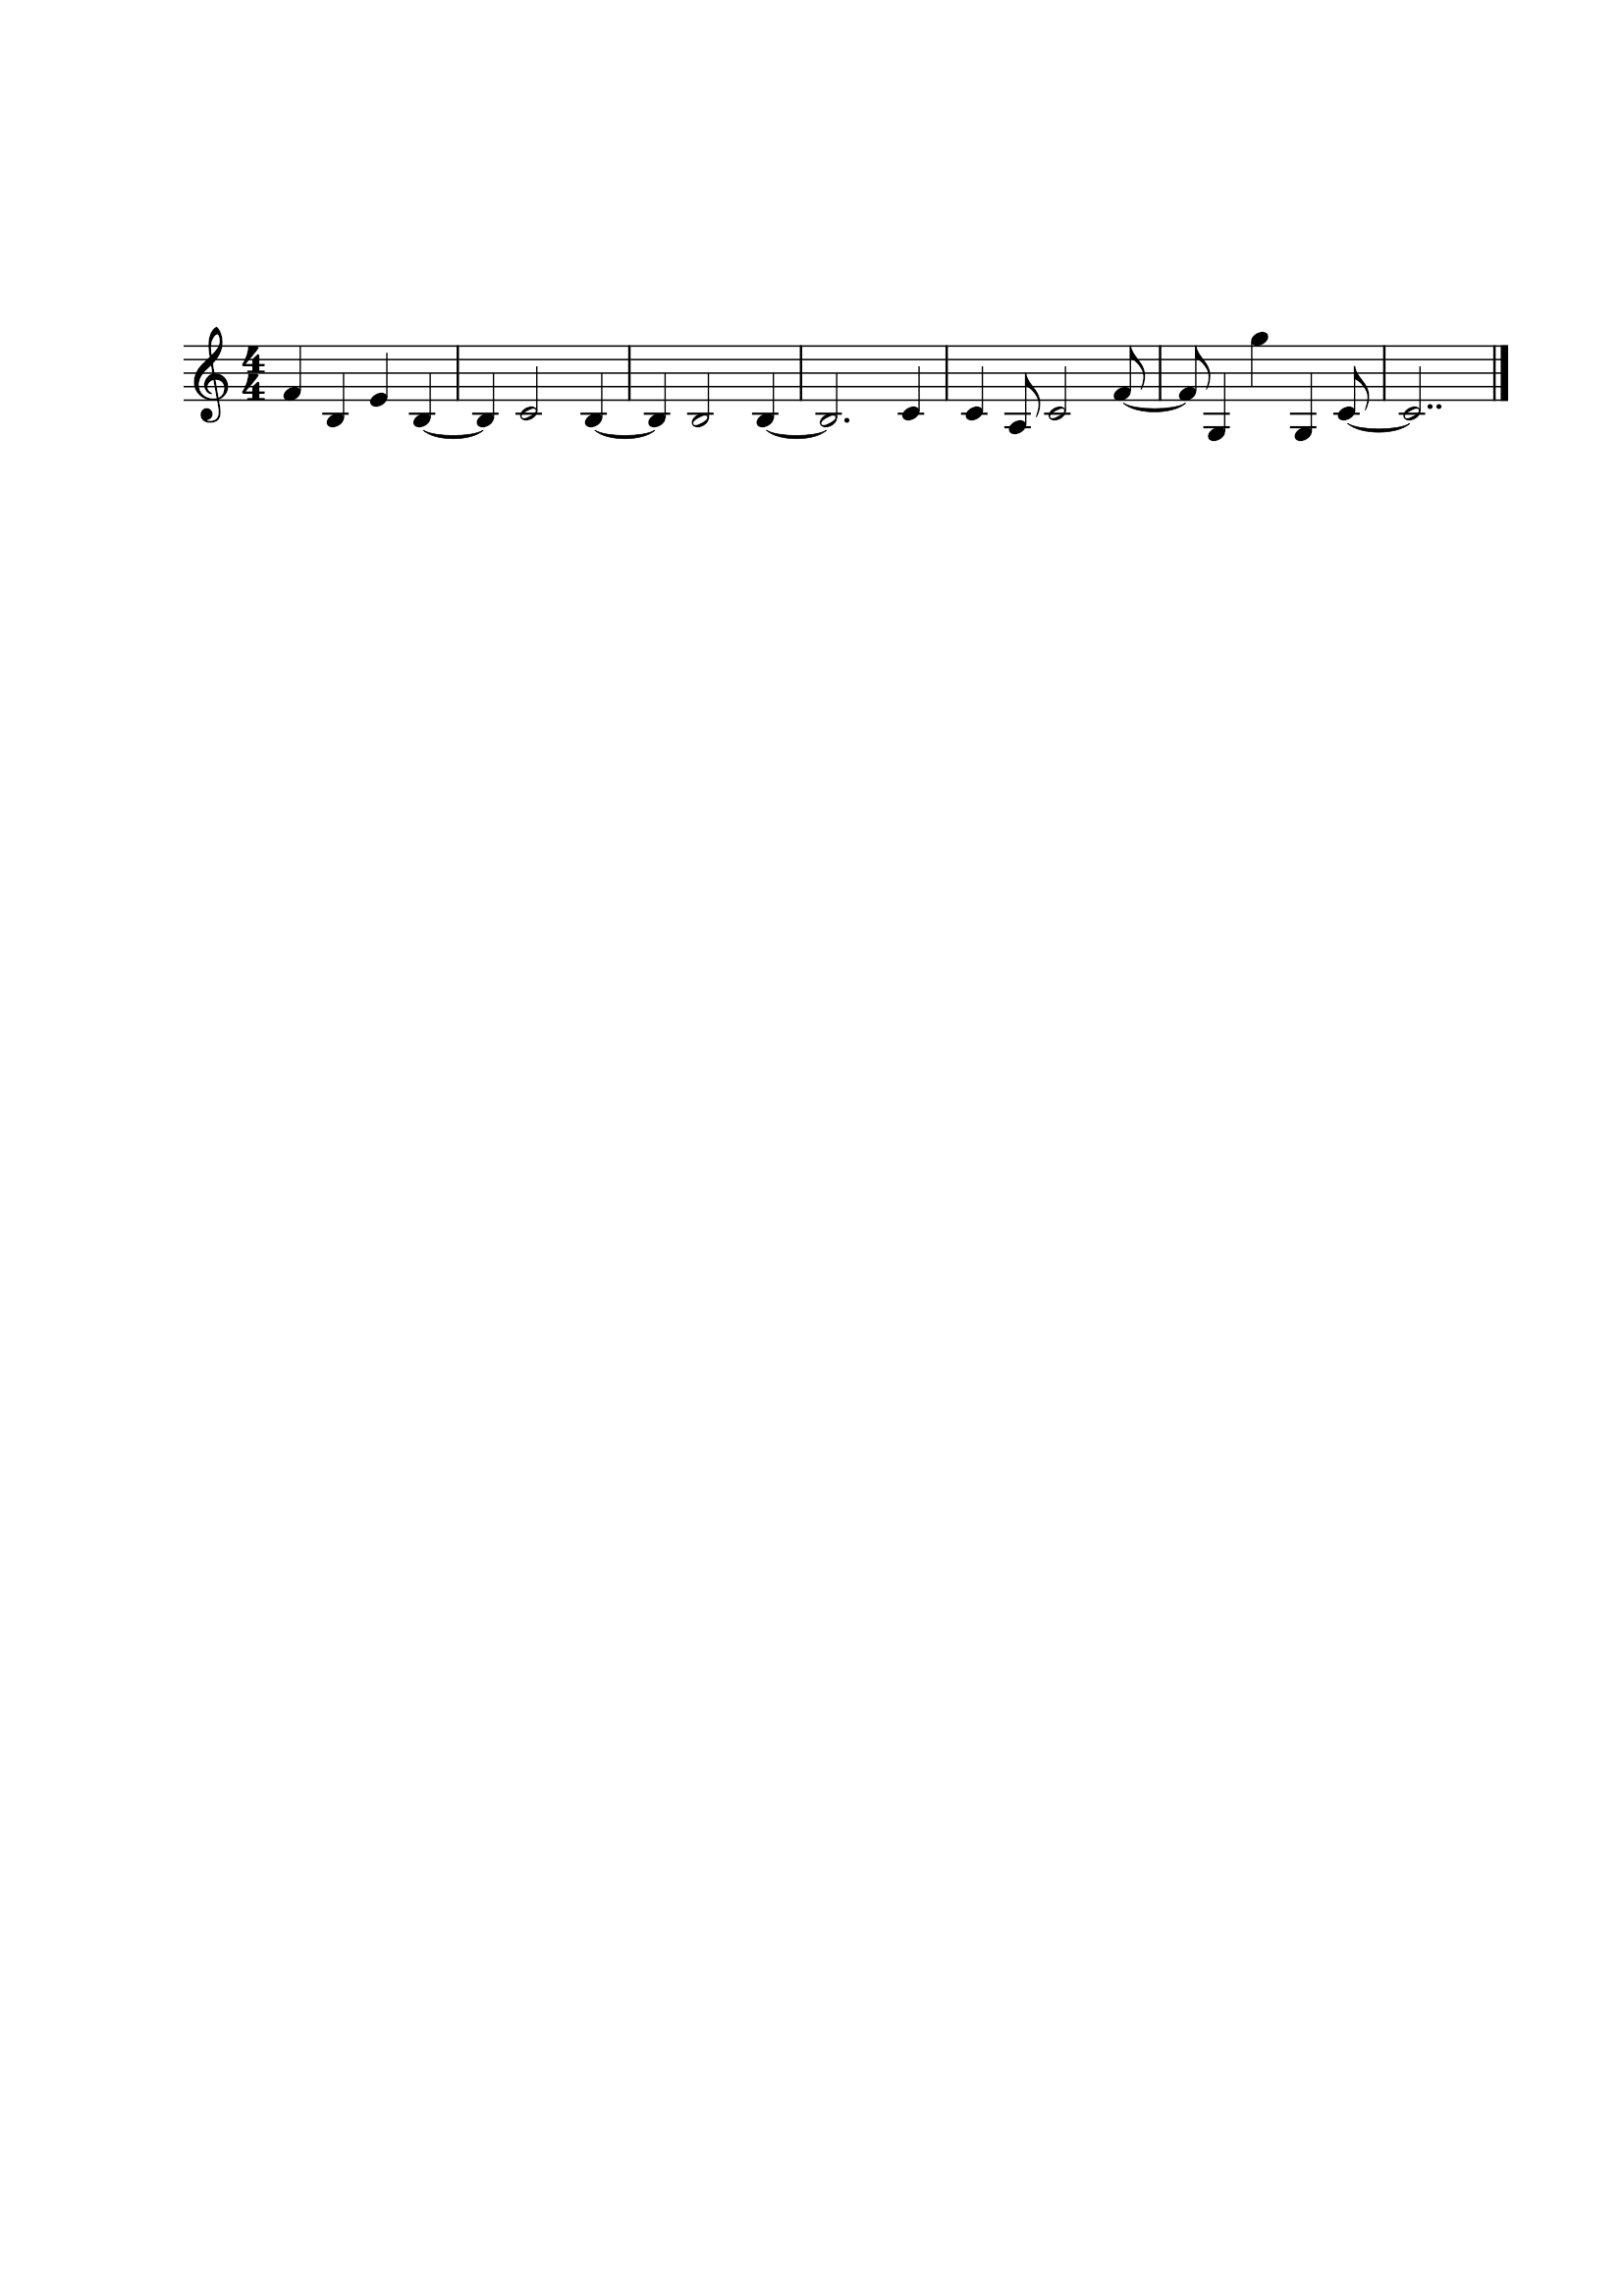

In [15]:
played_stream = stream.Stream(played_note)
played_stream.show()

In [16]:
music_stream.write('lily.pdf', fp='my_generated_music101')

NameError: name 'music_stream' is not defined